# Install Library

[RDKit ](https://github.com/rdkit/rdkit)

[DGL](https://github.com/dmlc/dgl/)

[DGL-LifeSci](https://github.com/awslabs/dgl-lifesci)





In [ ]:
%%capture
!git clone https://github.com/joerg84/Graph_Powered_ML_Workshop.git
!rsync -av Graph_Powered_ML_Workshop/ ./ --exclude=.git

In [ ]:
!pip3 install dgl

In [ ]:
%%capture
!pip install rdkit-pypi
!pip install dgl-cu111 
!pip install dgllife

# Import Library

In [1]:
import dgl
import sys
import torch
import random
import cv2
import torchvision
import pandas as pd
import numpy as np
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

from numpy import array
from numpy import argmax
from tensorflow.keras.utils import to_categorical
from dgllife.model import MLPPredictor
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, AttentiveFPAtomFeaturizer
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split

from utils.general import DATASET, get_dataset, separate_active_and_inactive_data, get_embedding_vector_class, count_lablel,data_generator
from utils.gcn_pre_trained import get_sider_model
from model.heterogeneous_siamese_sider import siamese_model_attentiveFp_sider, siamese_model_Canonical_sider

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [6]:
cache_path='./sider_dglgraph.bin'

df = get_dataset("sider")

In [7]:
sider_tasks = df.columns.values[1:].tolist()

In [8]:
from collections import Counter

one = []
zero = []

for task in sider_tasks:
  data = df[task]
  print(task ,":" ,Counter(data))
  zero.append(Counter(data)[0])
  one.append(Counter(data)[1])

Hepatobiliary disorders : Counter({1: 743, 0: 684})
Metabolism and nutrition disorders : Counter({1: 996, 0: 431})
Product issues : Counter({0: 1405, 1: 22})
Eye disorders : Counter({1: 876, 0: 551})
Investigations : Counter({1: 1151, 0: 276})
Musculoskeletal and connective tissue disorders : Counter({1: 997, 0: 430})
Gastrointestinal disorders : Counter({1: 1298, 0: 129})
Social circumstances : Counter({0: 1176, 1: 251})
Immune system disorders : Counter({1: 1024, 0: 403})
Reproductive system and breast disorders : Counter({1: 727, 0: 700})
Neoplasms benign, malignant and unspecified (incl cysts and polyps) : Counter({0: 1051, 1: 376})
General disorders and administration site conditions : Counter({1: 1292, 0: 135})
Endocrine disorders : Counter({0: 1104, 1: 323})
Surgical and medical procedures : Counter({0: 1214, 1: 213})
Vascular disorders : Counter({1: 1108, 0: 319})
Blood and lymphatic system disorders : Counter({1: 885, 0: 542})
Skin and subcutaneous tissue disorders : Counter({

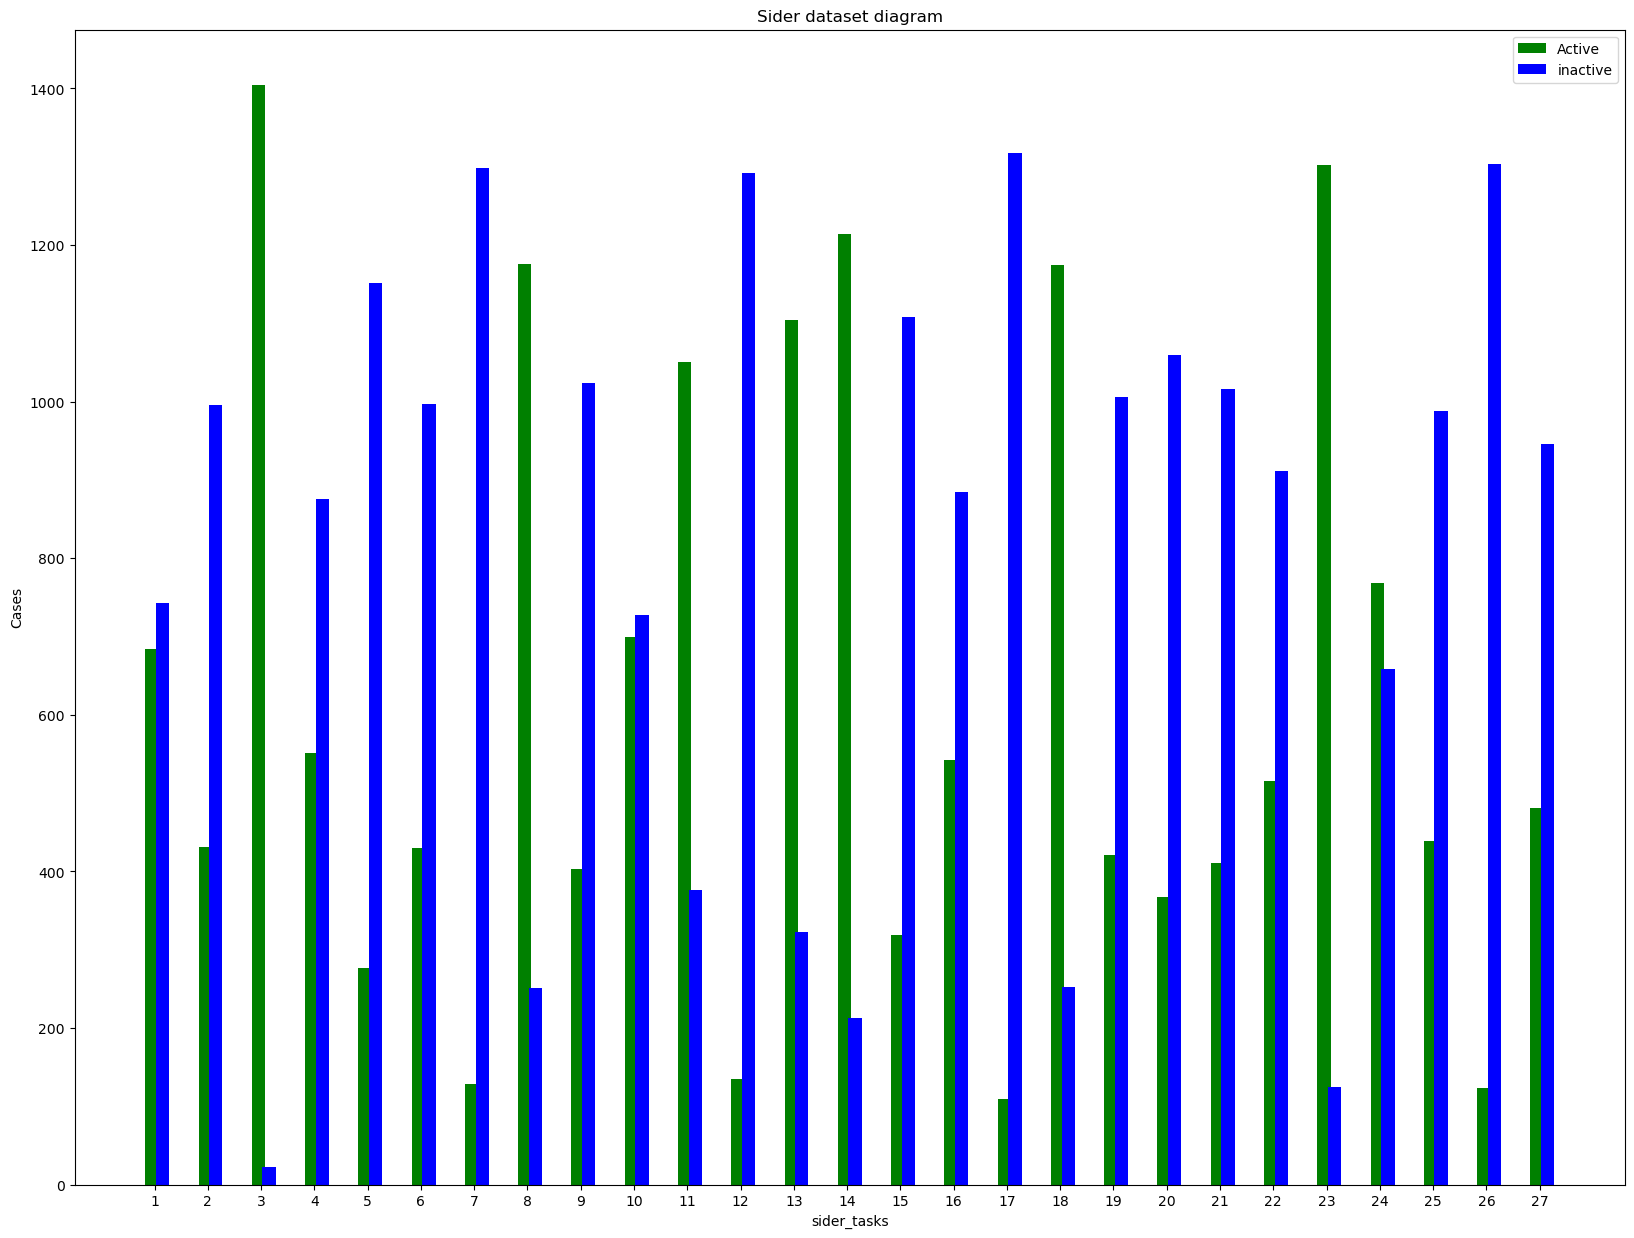

In [9]:
# Importing the matplotlib library
import numpy as np
import matplotlib.pyplot as plt
# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize=[20, 15])
# Data to be plotted
X = np.arange(1,len(sider_tasks)+1)

plt.bar(X + 0.20, zero, color = 'g', width = 0.25)
plt.bar(X + 0.4, one, color = 'b', width = 0.25)
# Creating the legend of the bars in the plot
plt.legend(['Active' , 'inactive' ])
# Overiding the x axis with the country names
plt.xticks([i + 0.25 for i in range(1,28)], X)
# Giving the tilte for the plot
plt.title("Sider dataset diagram")
# Namimg the x and y axis
plt.xlabel('sider_tasks')
plt.ylabel('Cases')
# Saving the plot as a 'png'
plt.savefig('4BarPlot.png')
# Displaying the bar plot
plt.show()

# Required functions

In [11]:
def create_dataset_with_gcn(dataset, class_embed_vector, GCN, tasks ):
    
    created_data = []
    data = np.arange(27)
    onehot_encoded = to_categorical(data)
    
    for i, data in enumerate(dataset):
        smiles, g, labels, mask = data
        g = g.to(device)
        g = dgl.add_self_loop(g)
        graph_feats = g.ndata.pop('h')
        embbed = GCN(g, graph_feats)
        embbed = embbed.to('cpu')
        embbed = embbed.detach().numpy()
        for j, label in enumerate(labels):
            a = (embbed, onehot_encoded[j], class_embed_vector[j], label, tasks[j])
            created_data.append(a)
    print('Data created!!')
    return created_data

# drug-based strategy with BioAct-Het

## Classification with BioAct-Het and AttentiveFp GCN

In [12]:
model_name = 'GCN_attentivefp_SIDER'
gcn_model = get_sider_model(model_name)
gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


In [12]:
from sklearn.model_selection import KFold

Epoch_S = 10

def evaluate_model(df, k = 10 , shuffle = False, tasks = sider_tasks):
    result =[]    

    kf = KFold(n_splits=10, shuffle= shuffle, random_state=None)
    
    for train_index, test_index in kf.split(df):

        train = df.iloc[train_index]
        test =  df.iloc[test_index]
        
        #Calculation of embedded vectors for each class
        df_train_positive, df_train_negative = Separate_active_and_inactive_data(train, tasks)
        df_test_positive, df_test_negative = Separate_active_and_inactive_data(test, tasks)
        
        dataset_positive_train = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_train_positive]
        dataset_negative_train = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_train_negative]    
        dataset_positive_test = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_test_positive]
        dataset_negative_test = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_test_negative]
        
        embed_class_sider_train = get_embedding_vector_class(dataset_positive_train, dataset_negative_train, radius=2, size = 512)
        embed_class_sider_test = get_embedding_vector_class(dataset_positive_test, dataset_negative_test, radius=2, size = 512)
       
        #create_dataset
        train_dataset = DATASET(train, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path)
        test_dataset = DATASET(test, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path)
                
        train_ds = create_dataset_with_gcn(train_dataset, embed_class_sider_train, gcn_model, tasks)
        valid_ds = create_dataset_with_gcn(test_dataset, embed_class_sider_test, gcn_model, tasks)
        
        label_pos , label_neg = count_lablel(train_ds)
        print(f'train positive label: {label_pos} - train negative label: {label_neg}')

        label_pos , label_neg = count_lablel(valid_ds)
        print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

        l_train = []
        r_train = []
        lbls_train = []
        
        l_valid = []
        r_valid = []
        lbls_valid = []

        for i , data in enumerate(train_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_train.append(embbed_drug[0])
            r_train.append(embbed_task)
            lbls_train.append(lbl.tolist())
        
        for i , data in enumerate(valid_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_valid.append(embbed_drug[0])
            r_valid.append(embbed_task)
            lbls_valid.append(lbl.tolist())

        l_train = np.array(l_train).reshape(-1,1024,1)
        r_train = np.array(r_train).reshape(-1,512,1)
        lbls_train = np.array(lbls_train)

        l_valid = np.array(l_valid).reshape(-1,1024,1)
        r_valid = np.array(r_valid).reshape(-1,512,1)
        lbls_valid = np.array(lbls_valid)

        # create neural network model
        siamese_net = siamese_model_attentiveFp_sider()
        history = History()
        P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])

        for j in range(100):
            C=1
            Before = int(P.history['accuracy'][-1]*100)
            for i in range(2,Epoch_S+1):
                if  int(P.history['accuracy'][-i]*100)== Before:
                    C=C+1
                else:
                    C=1
                Before=int(P.history['accuracy'][-i]*100)
                print(Before)
            if C==Epoch_S:
                break
            P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])
        print(j+1)
        
        score  = siamese_net.evaluate([l_valid,r_valid],lbls_valid, verbose=1)
        a = (score[1],score[4])
        result.append(a)
    
    return result
 
 
scores = evaluate_model(df, 10, False, sider_tasks)

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1033
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1176
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1165
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1189
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Proces

271/271 [==============================] - 3s 11ms/step - loss: 0.3576 - accuracy: 0.8360 - mae: 0.2291 - mse: 0.1137 - auc: 0.9189
Epoch 6/10
271/271 [==============================] - 3s 13ms/step - loss: 0.3563 - accuracy: 0.8383 - mae: 0.2265 - mse: 0.1130 - auc: 0.9198
Epoch 7/10
271/271 [==============================] - 3s 13ms/step - loss: 0.3533 - accuracy: 0.8397 - mae: 0.2258 - mse: 0.1124 - auc: 0.9208
Epoch 8/10
271/271 [==============================] - 3s 13ms/step - loss: 0.3529 - accuracy: 0.8396 - mae: 0.2253 - mse: 0.1120 - auc: 0.9213
Epoch 9/10
271/271 [==============================] - 3s 12ms/step - loss: 0.3509 - accuracy: 0.8395 - mae: 0.2233 - mse: 0.1110 - auc: 0.9224
Epoch 10/10
271/271 [==============================] - 3s 12ms/step - loss: 0.3486 - accuracy: 0.8406 - mae: 0.2224 - mse: 0.1107 - auc: 0.9228
83
83
83
83
83
83
83
83
83
Epoch 1/10
271/271 [==============================] - 3s 12ms/step - loss: 0.3464 - accuracy: 0.8441 - mae: 0.2211 - mse: 0.1

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1091
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1057
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1170
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch..

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1176
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graph

271/271 [==============================] - 6s 21ms/step - loss: 0.3708 - accuracy: 0.8292 - mae: 0.2379 - mse: 0.1183 - auc_4: 0.9130
82
82
82
82
82
82
82
82
82
2
121/121 [==============================] - 0s 3ms/step - loss: 0.5871 - accuracy: 0.7949 - mae: 0.2350 - mse: 0.1532 - auc_4: 0.8643
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1036
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1164
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1161
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Proces

271/271 [==============================] - 5s 17ms/step - loss: 0.4264 - accuracy: 0.8064 - mae: 0.2747 - mse: 0.1364 - auc_6: 0.8840
Epoch 5/10
271/271 [==============================] - 5s 17ms/step - loss: 0.4145 - accuracy: 0.8109 - mae: 0.2669 - mse: 0.1327 - auc_6: 0.8902
Epoch 6/10
271/271 [==============================] - 5s 17ms/step - loss: 0.4063 - accuracy: 0.8150 - mae: 0.2611 - mse: 0.1298 - auc_6: 0.8949
Epoch 7/10
271/271 [==============================] - 5s 17ms/step - loss: 0.4019 - accuracy: 0.8178 - mae: 0.2581 - mse: 0.1278 - auc_6: 0.8981
Epoch 8/10
271/271 [==============================] - 5s 17ms/step - loss: 0.3960 - accuracy: 0.8192 - mae: 0.2546 - mse: 0.1264 - auc_6: 0.9005
Epoch 9/10
271/271 [==============================] - 5s 17ms/step - loss: 0.3936 - accuracy: 0.8204 - mae: 0.2521 - mse: 0.1254 - auc_6: 0.9020
Epoch 10/10
271/271 [==============================] - 5s 17ms/step - loss: 0.3882 - accuracy: 0.8240 - mae: 0.2490 - mse: 0.1234 - auc_6: 0.

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing d

Processing molecule 1000/1059
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1093
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1053
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1172
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Proces

272/272 [==============================] - 4s 14ms/step - loss: 0.4075 - accuracy: 0.8146 - mae: 0.2619 - mse: 0.1303 - auc_9: 0.8938
Epoch 7/10
272/272 [==============================] - 4s 14ms/step - loss: 0.4029 - accuracy: 0.8137 - mae: 0.2598 - mse: 0.1289 - auc_9: 0.8964
Epoch 8/10
272/272 [==============================] - 4s 14ms/step - loss: 0.3958 - accuracy: 0.8168 - mae: 0.2546 - mse: 0.1268 - auc_9: 0.8999
Epoch 9/10
272/272 [==============================] - 4s 14ms/step - loss: 0.3956 - accuracy: 0.8184 - mae: 0.2544 - mse: 0.1264 - auc_9: 0.9002
Epoch 10/10
272/272 [==============================] - 4s 14ms/step - loss: 0.3904 - accuracy: 0.8206 - mae: 0.2515 - mse: 0.1250 - auc_9: 0.9027
81
81
81
81
81
80
79
78
74
Epoch 1/10
272/272 [==============================] - 4s 14ms/step - loss: 0.3881 - accuracy: 0.8234 - mae: 0.2499 - mse: 0.1238 - auc_9: 0.9045
Epoch 2/10
272/272 [==============================] - 4s 14ms/step - loss: 0.3820 - accuracy: 0.8235 - mae: 0.245

In [1]:
scores

NameError: name 'scores' is not defined

In [14]:
acc = []
auc = []
for i in scores:
    acc.append(i[0])
    auc.append(i[1])
print(f'accuracy= {np.mean(acc)} AUC= {np.mean(auc)}')

accuracy= 0.7726572275161743 AUC= 0.8483467936515808


## Classification with BioAct-Het and Canonical GCN 

In [15]:
model_name = 'GCN_canonical_SIDER'
gcn_model = get_sider_model(model_name)
gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


In [22]:
from sklearn.model_selection import KFold

Epoch_S = 10

def evaluate_model(df, k = 10 , shuffle = False , tasks = sider_tasks):
    result =[]    

    kf = KFold(n_splits=10, shuffle = shuffle, random_state=None)
    
    for train_index, test_index in kf.split(df):

        train = df.iloc[train_index]
        test =  df.iloc[test_index]
        
        #Calculation of embedded vectors for each class
        df_train_positive, df_train_negative = Separate_active_and_inactive_data(train, tasks)
        df_test_positive, df_test_negative = Separate_active_and_inactive_data(test, tasks)
        
        dataset_positive_train = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_train_positive]
        dataset_negative_train = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_train_negative]    
        dataset_positive_test = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_test_positive]
        dataset_negative_test = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_test_negative]
        
        embed_class_sider_train = get_embedding_vector_class(dataset_positive_train, dataset_negative_train, radius=2, size = 512)
        embed_class_sider_test = get_embedding_vector_class(dataset_positive_test, dataset_negative_test, radius=2, size = 512)
       
        #create_dataset
        train_dataset = DATASET(train, smiles_to_bigraph, CanonicalAtomFeaturizer(), cache_file_path = cache_path)
        test_dataset = DATASET(test, smiles_to_bigraph, CanonicalAtomFeaturizer(), cache_file_path = cache_path)
                
        train_ds = create_dataset_with_gcn(train_dataset, embed_class_sider_train, gcn_model, tasks)
        valid_ds = create_dataset_with_gcn(test_dataset, embed_class_sider_test, gcn_model, tasks)
        
        label_pos , label_neg = count_lablel(train_ds)
        print(f'train positive label: {label_pos} - train negative label: {label_neg}')

        label_pos , label_neg = count_lablel(valid_ds)
        print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

        l_train = []
        r_train = []
        lbls_train = []
        l_valid = []
        r_valid = []
        lbls_valid = []

        for i , data in enumerate(train_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_train.append(embbed_drug[0])
            r_train.append(embbed_task)
            lbls_train.append(lbl.tolist())
        
        for i , data in enumerate(valid_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_valid.append(embbed_drug[0])
            r_valid.append(embbed_task)
            lbls_valid.append(lbl.tolist())

        l_train = np.array(l_train).reshape(-1,512,1)
        r_train = np.array(r_train).reshape(-1,512,1)
        lbls_train = np.array(lbls_train)

        l_valid = np.array(l_valid).reshape(-1,512,1)
        r_valid = np.array(r_valid).reshape(-1,512,1)
        lbls_valid = np.array(lbls_valid)

        # create neural network model
        siamese_net = siamese_model_Canonical_sider()
        history = History()
        P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])

        for j in range(100):
            C=1
            Before = int(P.history['accuracy'][-1]*100)
            for i in range(2,Epoch_S+1):
                if  int(P.history['accuracy'][-i]*100)== Before:
                    C=C+1
                else:
                    C=1
                Before=int(P.history['accuracy'][-i]*100)
                print(Before)
            if C==Epoch_S:
                break
            P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])
        print(j+1)
        
        score  = siamese_net.evaluate([l_valid,r_valid],lbls_valid, verbose=1)
        a = (score[1],score[4])
        result.append(a)
    
    return result
 
 
scores = evaluate_model(df, 10, False, sider_tasks)

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1033
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1176
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1165
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1189
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Proces

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
class vector created!!
class vector created!!
Processing dgl graphs from scratch...
Processing molecule 1000/1284
Processing dgl graphs from scratch...
Data created!!
Data created!!
train positive label: 19821 - train negative label: 14847
Test positive label: 2047 - Test negative label: 1814
Epoch 1/10
271/271 [==============================] - 2s 7ms/step - loss: 0.5446 - accuracy: 0.7365 - mae: 0.3626 - mse: 0.1814 - auc_14: 0.7953
Epoch 2/10
271/271 [==============================] - 2s 7ms/step - loss: 0.4911 - accuracy: 0.7753 - mae: 0.3213 - mse: 0.1601 - auc_14: 0.8377
Epoch 3/10
271/271 [==============================] - 2s 7ms/step - loss: 

Processing molecule 1000/1061
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1091
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1057
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1170
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Proces

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
class vector created!!
class vector created!!
Processing dgl graphs from scratch...
Processing molecule 1000/1284
Processing dgl graphs from scratch...
Data created!!
Data created!!
train positive label: 19520 - train negative label: 15148
Test positive label: 2348 - Test negative label: 1513
Epoch 1/10
271/271 [==============================] - 2s 8ms/step - loss: 0.5305 - accuracy: 0.7486 - mae: 0.3519 - mse: 0.1752 - auc_16: 0.8074
Epoch 2/10
271/271 [==============================] - 2s 8ms/step - loss: 0.4932 - accuracy: 0.7739 - mae: 0.3234 - mse: 0.1607 - auc_16: 0.8381
Epoch 3/10
271/271 [==============================] - 2s 8ms/step - loss: 0.4792 - accuracy: 0.7803 - mae: 0.3135 - mse: 0.1557 - auc_16: 0.8479
Epoch 4/10
271/271 [==============================] - 2s 8ms/step - loss: 0.4772 

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
class vector created!!
class vector created!!
Processing dgl graphs from scratch...
Processing molecule 1000/1284
Processing dgl graphs from scratch...
Data created!!
Data created!!
train positive label: 19537 - train negative label: 15131
Test positive label: 2331 - Test negative label: 1530
Epoch 1/10
271/271 [==============================] - 2s 7ms/step - loss: 0.5296 - accuracy: 0.7435 - mae: 0.3528 - mse: 0.1759 - auc_17: 0.8053
Epoch 2/10
271/271 [==============================] - 2s 7ms/step -

271/271 [==============================] - 2s 9ms/step - loss: 0.4341 - accuracy: 0.8022 - mae: 0.2811 - mse: 0.1397 - auc_18: 0.8777
Epoch 4/10
271/271 [==============================] - 2s 9ms/step - loss: 0.4301 - accuracy: 0.8034 - mae: 0.2787 - mse: 0.1385 - auc_18: 0.8800
Epoch 5/10
271/271 [==============================] - 2s 9ms/step - loss: 0.4283 - accuracy: 0.8050 - mae: 0.2768 - mse: 0.1376 - auc_18: 0.8814
Epoch 6/10
271/271 [==============================] - 2s 9ms/step - loss: 0.4256 - accuracy: 0.8042 - mae: 0.2750 - mse: 0.1368 - auc_18: 0.8831
Epoch 7/10
271/271 [==============================] - 2s 9ms/step - loss: 0.4203 - accuracy: 0.8092 - mae: 0.2716 - mse: 0.1349 - auc_18: 0.8862
Epoch 8/10
271/271 [==============================] - 2s 9ms/step - loss: 0.4191 - accuracy: 0.8089 - mae: 0.2702 - mse: 0.1342 - auc_18: 0.8872
Epoch 9/10
271/271 [==============================] - 2s 9ms/step - loss: 0.4141 - accuracy: 0.8117 - mae: 0.2668 - mse: 0.1324 - auc_18: 0.8

271/271 [==============================] - 2s 8ms/step - loss: 0.4534 - accuracy: 0.7921 - mae: 0.2952 - mse: 0.1468 - auc_19: 0.8646
79
78
78
78
78
77
77
77
73
Epoch 1/10
271/271 [==============================] - 2s 8ms/step - loss: 0.4471 - accuracy: 0.7959 - mae: 0.2905 - mse: 0.1443 - auc_19: 0.8692
Epoch 2/10
271/271 [==============================] - 2s 8ms/step - loss: 0.4474 - accuracy: 0.7972 - mae: 0.2895 - mse: 0.1438 - auc_19: 0.8697
Epoch 3/10
271/271 [==============================] - 2s 9ms/step - loss: 0.4414 - accuracy: 0.7971 - mae: 0.2862 - mse: 0.1426 - auc_19: 0.8729
Epoch 4/10
271/271 [==============================] - 2s 9ms/step - loss: 0.4382 - accuracy: 0.8005 - mae: 0.2838 - mse: 0.1411 - auc_19: 0.8752
Epoch 5/10
271/271 [==============================] - 2s 8ms/step - loss: 0.4358 - accuracy: 0.8006 - mae: 0.2825 - mse: 0.1402 - auc_19: 0.8770
Epoch 6/10
271/271 [==============================] - 2s 9ms/step - loss: 0.4313 - accuracy: 0.8045 - mae: 0.2785 

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
class vector created!!
class vector created!!
Proc

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1172
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1264
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1059
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1093
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Proces

Epoch 1/10
272/272 [==============================] - 2s 7ms/step - loss: 0.3895 - accuracy: 0.8231 - mae: 0.2505 - mse: 0.1244 - auc_21: 0.9033
Epoch 2/10
272/272 [==============================] - 2s 7ms/step - loss: 0.3904 - accuracy: 0.8233 - mae: 0.2508 - mse: 0.1245 - auc_21: 0.9030
Epoch 3/10
272/272 [==============================] - 2s 7ms/step - loss: 0.3888 - accuracy: 0.8247 - mae: 0.2494 - mse: 0.1239 - auc_21: 0.9037
Epoch 4/10
272/272 [==============================] - 2s 7ms/step - loss: 0.3862 - accuracy: 0.8251 - mae: 0.2481 - mse: 0.1233 - auc_21: 0.9047
Epoch 5/10
272/272 [==============================] - 2s 7ms/step - loss: 0.3836 - accuracy: 0.8260 - mae: 0.2463 - mse: 0.1223 - auc_21: 0.9061
Epoch 6/10
272/272 [==============================] - 2s 7ms/step - loss: 0.3823 - accuracy: 0.8276 - mae: 0.2452 - mse: 0.1218 - auc_21: 0.9069
Epoch 7/10
272/272 [==============================] - 2s 7ms/step - loss: 0.3819 - accuracy: 0.8261 - mae: 0.2452 - mse: 0.1219 - 

Processing dgl graphs from scratch...
Processing molecule 1000/1193
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1177
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1265
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/1051
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Proces

In [23]:
scores

[(0.7417767643928528, 0.8250888586044312),
 (0.752913773059845, 0.8265397548675537),
 (0.7619787454605103, 0.8200584650039673),
 (0.7700077891349792, 0.81299889087677),
 (0.7767418026924133, 0.8194084763526917),
 (0.7658637762069702, 0.8277521133422852),
 (0.7842527627944946, 0.8390901684761047),
 (0.7660406827926636, 0.8311195969581604),
 (0.7230046987533569, 0.7504766583442688),
 (0.7769953012466431, 0.8399366140365601)]

In [24]:
acc = []
auc = []
for i in scores:
    acc.append(i[0])
    auc.append(i[1])
print(f'accuracy= {np.mean(acc)} AUC= {np.mean(auc)}')

accuracy= 0.7619576096534729 AUC= 0.8192469596862793
